In [ ]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a7936f9674ddc57abab878f12af5314620f49b65be016ec314d4a64bbb0c46a1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .appName("OlaDataAnalysis") \
    .getOrCreate()

# Load data from CSV
csv_file_path = "/content/ola_data1.csv"
ola_data_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
ola_data_df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: int, trip_distance: double, pickup_longitude: double, pickup_latitude: double, RatecodeID: int, store_and_fwd_flag: string, dropoff_longitude: double, dropoff_latitude: double, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double]

In [ ]:
from pyspark.sql.functions import col, hour, dayofmonth, month, year, dayofweek, monotonically_increasing_id

# Convert pickup and dropoff datetime columns to datetime type
ola_data_df = ola_data_df.withColumn('tpep_pickup_datetime', ola_data_df['tpep_pickup_datetime'].cast('timestamp'))
ola_data_df = ola_data_df.withColumn('tpep_dropoff_datetime', ola_data_df['tpep_dropoff_datetime'].cast('timestamp'))


# Extract datetime dimensions
datetime_dim = ola_data_df.select(
    ola_data_df['tpep_pickup_datetime'],
    ola_data_df['tpep_dropoff_datetime']
).distinct().select(
    col('tpep_pickup_datetime').alias('pickup_datetime'),
    col('tpep_dropoff_datetime').alias('dropoff_datetime')
)

datetime_dim = datetime_dim.withColumn('pick_hour', hour('pickup_datetime'))
datetime_dim = datetime_dim.withColumn('pick_day', dayofmonth('pickup_datetime'))
datetime_dim = datetime_dim.withColumn('pick_month', month('pickup_datetime'))
datetime_dim = datetime_dim.withColumn('pick_year', year('pickup_datetime'))
datetime_dim = datetime_dim.withColumn('pick_weekday', dayofweek('pickup_datetime'))

datetime_dim = datetime_dim.withColumn('drop_hour', hour('dropoff_datetime'))
datetime_dim = datetime_dim.withColumn('drop_day', dayofmonth('dropoff_datetime'))
datetime_dim = datetime_dim.withColumn('drop_month', month('dropoff_datetime'))
datetime_dim = datetime_dim.withColumn('drop_year', year('dropoff_datetime'))
datetime_dim = datetime_dim.withColumn('drop_weekday', dayofweek('dropoff_datetime'))

# Create a datetime_id column
datetime_dim = datetime_dim.withColumn('datetime_id', monotonically_increasing_id())

# Select relevant columns
datetime_dim = datetime_dim.select(
    'datetime_id', 'pickup_datetime', 'pick_hour', 'pick_day', 'pick_month', 'pick_year', 'pick_weekday',
    'dropoff_datetime', 'drop_hour', 'drop_day', 'drop_month', 'drop_year', 'drop_weekday'
)

# Display datetime_dim DataFrame
datetime_dim.show()

# passenger_count_dim
passenger_count_dim = ola_data_df.select('passenger_count').distinct().withColumnRenamed('passenger_count', 'passenger_count_id')

# Create a passenger_count_id column
passenger_count_dim = passenger_count_dim.withColumn('passenger_count_id', monotonically_increasing_id())

# Display passenger_count_dim DataFrame
passenger_count_dim.show()

# trip_distance_dim
trip_distance_dim = ola_data_df.select('trip_distance').distinct().withColumnRenamed('trip_distance', 'trip_distance_id')

# Create a trip_distance_id column
trip_distance_dim = trip_distance_dim.withColumn('trip_distance_id', monotonically_increasing_id())

# Display trip_distance_dim DataFrame
trip_distance_dim.show()

# rate_code_dim
rate_code_type = {
    1: "Standard rate",
    2: "JFK",
    3: "Newark",
    4: "Nassau or Westchester",
    5: "Negotiated fare",
    6: "Group ride"
}

rate_code_dim = spark.createDataFrame(
    [(k, v) for k, v in rate_code_type.items()],
    ['RatecodeID', 'rate_code_name']
)

rate_code_dim = rate_code_dim.withColumn('rate_code_id', monotonically_increasing_id())

# Display rate_code_dim DataFrame
rate_code_dim.show()


+-----------+-------------------+---------+--------+----------+---------+------------+-------------------+---------+--------+----------+---------+------------+
|datetime_id|    pickup_datetime|pick_hour|pick_day|pick_month|pick_year|pick_weekday|   dropoff_datetime|drop_hour|drop_day|drop_month|drop_year|drop_weekday|
+-----------+-------------------+---------+--------+----------+---------+------------+-------------------+---------+--------+----------+---------+------------+
|          0|2016-03-10 07:07:32|        7|      10|         3|     2016|           5|2016-03-10 07:23:35|        7|      10|         3|     2016|           5|
|          1|2016-03-10 07:07:56|        7|      10|         3|     2016|           5|2016-03-10 07:22:02|        7|      10|         3|     2016|           5|
|          2|2016-03-10 07:09:03|        7|      10|         3|     2016|           5|2016-03-10 07:15:34|        7|      10|         3|     2016|           5|
|          3|2016-03-10 07:09:23|       

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# pickup_location_dim
pickup_location_dim = ola_data_df.select('pickup_longitude', 'pickup_latitude').distinct().withColumnRenamed('pickup_latitude', 'latitude').withColumnRenamed('pickup_longitude', 'longitude')

# Create a pickup_location_id column
pickup_location_dim = pickup_location_dim.withColumn('pickup_location_id', monotonically_increasing_id())

# Display pickup_location_dim DataFrame
pickup_location_dim.show()

# dropoff_location_dim
dropoff_location_dim = ola_data_df.select('dropoff_longitude', 'dropoff_latitude').distinct().withColumnRenamed('dropoff_latitude', 'latitude').withColumnRenamed('dropoff_longitude', 'longitude')

# Create a dropoff_location_id column
dropoff_location_dim = dropoff_location_dim.withColumn('dropoff_location_id', monotonically_increasing_id())

# Display dropoff_location_dim DataFrame
dropoff_location_dim.show()

# payment_type_dim
payment_type_name = {
    1: "Credit card",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided trip"
}

payment_type_dim = spark.createDataFrame([(k, v) for k, v in payment_type_name.items()], ['payment_type', 'payment_type_name'])

# Create a payment_type_id column
payment_type_dim = payment_type_dim.withColumn('payment_type_id', monotonically_increasing_id())

# Display payment_type_dim DataFrame
payment_type_dim.show()

# Merge all dimensions to create the fact table
# Merge all dimensions to create the fact table
# Merge all dimensions to create the fact table
fact_table = ola_data_df.join(passenger_count_dim, ola_data_df['passenger_count'] == passenger_count_dim['passenger_count_id']) \
             .join(trip_distance_dim, ola_data_df['trip_distance'] == trip_distance_dim['trip_distance_id']) \
             .join(rate_code_dim, ola_data_df['RatecodeID'] == rate_code_dim['rate_code_id']) \
             .join(pickup_location_dim, (ola_data_df['pickup_longitude'] == pickup_location_dim['longitude']) & (ola_data_df['pickup_latitude'] == pickup_location_dim['latitude'])) \
             .join(dropoff_location_dim, (ola_data_df['dropoff_longitude'] == dropoff_location_dim['longitude']) & (ola_data_df['dropoff_latitude'] == dropoff_location_dim['latitude'])) \
             .join(datetime_dim, (ola_data_df['tpep_pickup_datetime'] == datetime_dim['pickup_datetime']) & (ola_data_df['tpep_dropoff_datetime'] == datetime_dim['dropoff_datetime'])) \
             .join(payment_type_dim, ola_data_df['payment_type'] == payment_type_dim['payment_type']) \
             .select('VendorID', 'datetime_id', 'passenger_count_id',
                     'trip_distance_id', 'rate_code_id', 'store_and_fwd_flag',
                     'pickup_location_id', 'dropoff_location_id', 'payment_type_id',
                     'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                     'improvement_surcharge', 'total_amount')

# Display fact_table DataFrame
fact_table.show()



+------------------+------------------+------------------+
|         longitude|          latitude|pickup_location_id|
+------------------+------------------+------------------+
|-73.93929290771484| 40.84185028076172|                 0|
|-73.97794342041014| 40.77862930297852|                 1|
|-73.97701263427734|40.774707794189446|                 2|
| -73.9498519897461| 40.78435897827149|                 3|
|-73.98612213134764|  40.7264404296875|                 4|
|-73.99044036865233|40.756053924560554|                 5|
|-73.96515655517578| 40.79605102539063|                 6|
|-74.00804901123048| 40.71493911743164|                 7|
|-73.97512054443358| 40.75249862670898|                 8|
|-73.96880340576173| 40.78507995605469|                 9|
| -73.8633270263672|40.769580841064446|                10|
|-73.98265838623048| 40.77734756469727|                11|
|-73.94937133789062| 40.77684783935546|                12|
| -73.9841537475586| 40.78036117553711|                1

In [ ]:
# Count the number of missing values in each column
import pyspark.sql.functions as F
missing_counts = ola_data_df.select([
    F.count(F.when(F.isnull(c), c)).alias(c)
    for c in ola_data_df.columns
    if ola_data_df.schema[c].dataType != 'timestamp'
]).show()


+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|RatecodeID|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       0|                   0|                    0|              0|            0|               0|              0|         0|                 0|              

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+------------------+---------------

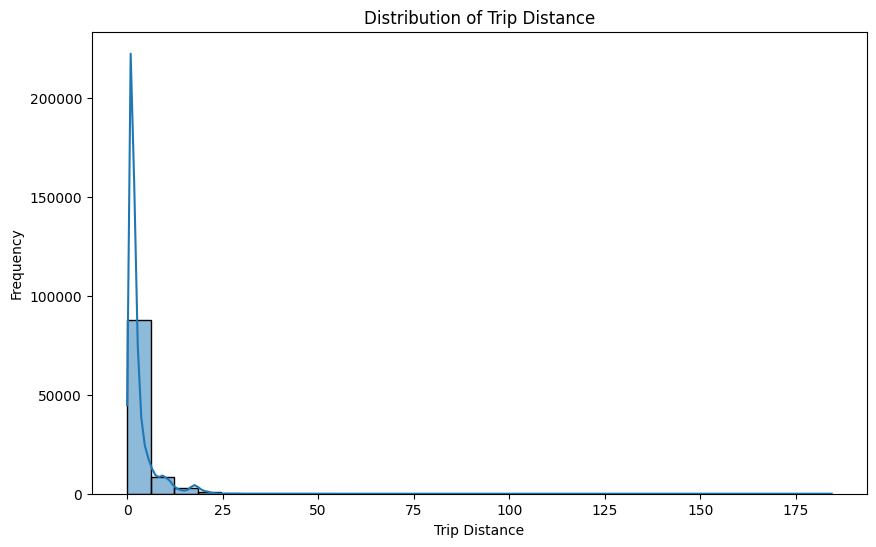

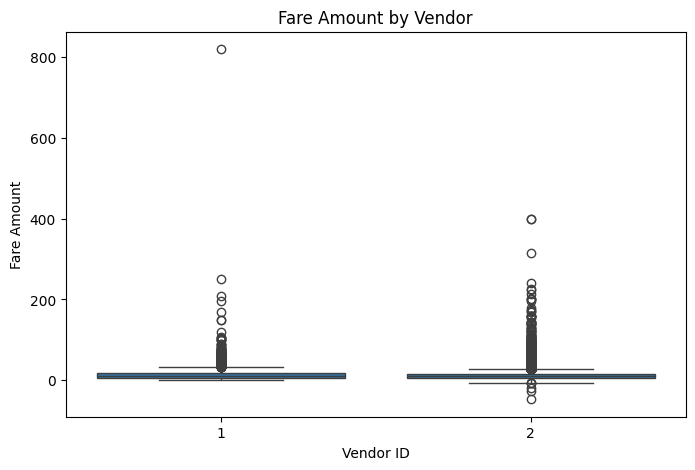

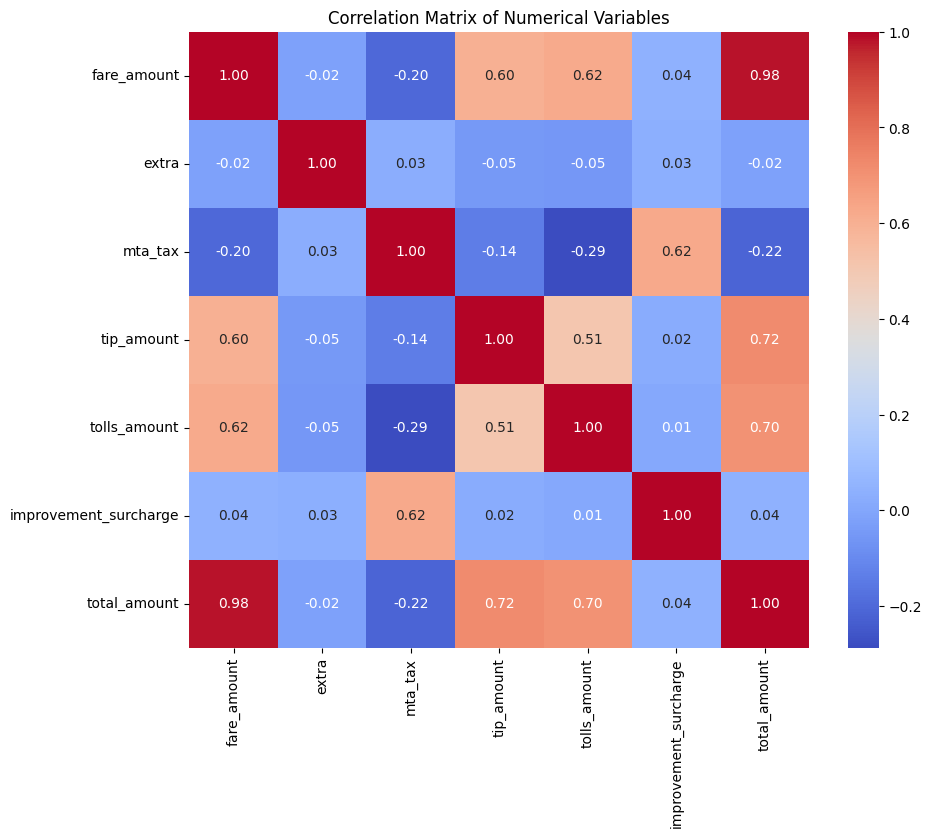

In [ ]:
# Import necessary libraries
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Create a SparkSession
spark = SparkSession.builder \
    .appName("EDA") \
    .getOrCreate()

# Load your DataFrame
# Assuming ola_data_df is your DataFrame

# Show the schema of your DataFrame
ola_data_df.printSchema()

# Display the first few rows of your DataFrame
ola_data_df.show(5)

# Summary statistics for numerical columns
ola_data_df.describe().show()
'''
# Count the number of missing values in each column
ola_data_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for c in ola_data_df.columns]).show()
'''
missing_counts = ola_data_df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in ola_data_df.columns
]).show()
# Check the distribution of categorical variables
ola_data_df.groupBy('VendorID').count().show()
ola_data_df.groupBy('store_and_fwd_flag').count().show()
ola_data_df.groupBy('payment_type').count().show()

# Visualize the distribution of numerical variables
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for visualization
ola_data_pd = ola_data_df.toPandas()

# Example: Histogram of trip distance
plt.figure(figsize=(10, 6))
sns.histplot(ola_data_pd['trip_distance'], bins=30, kde=True)
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Distance')
plt.show()

# Example: Boxplot of fare amount
plt.figure(figsize=(8, 5))
sns.boxplot(x='VendorID', y='fare_amount', data=ola_data_pd)
plt.xlabel('Vendor ID')
plt.ylabel('Fare Amount')
plt.title('Fare Amount by Vendor')
plt.show()

# Correlation matrix for numerical variables
numeric_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
numeric_df = ola_data_df.select(numeric_cols)
corr_matrix = numeric_df.toPandas().corr()

# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Stop the SparkSession
spark.stop()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when, to_timestamp, dayofmonth, hour, minute, lit
from pyspark.sql.types import IntegerType, DoubleType

# Create SparkSession
spark = SparkSession.builder \
    .appName("FeatureEngineering") \
    .getOrCreate()

# Assuming you have already loaded the data into ola_data_df DataFrame

# 1. Distance-based features
ola_data_df = ola_data_df.withColumn('trip_distance_in_miles', col('trip_distance') * 0.621371)  # Convert kilometers to miles

# 2. Time-based features
# Handle potential errors in datetime format (replace format if needed)
try:
    # Ensure consistent datetime format
    ola_data_df = ola_data_df.withColumn('tpep_pickup_datetime', to_timestamp(col('tpep_pickup_datetime'), 'yyyy-MM-dd HH:mm:ss'))
    ola_data_df = ola_data_df.withColumn('tpep_dropoff_datetime', to_timestamp(col('tpep_dropoff_datetime'), 'yyyy-MM-dd HH:mm:ss'))
except Exception as e:
    print("Error:", e, "during datetime conversion. Check format and data types.")

# Extract additional time components
ola_data_df = ola_data_df.withColumn('pickup_hour', hour(col('tpep_pickup_datetime')))
ola_data_df = ola_data_df.withColumn('pickup_minute', minute(col('tpep_pickup_datetime')))
ola_data_df = ola_data_df.withColumn('dropoff_hour', hour(col('tpep_dropoff_datetime')))
ola_data_df = ola_data_df.withColumn('dropoff_minute', minute(col('tpep_dropoff_datetime')))

# 3. Time difference features (assuming numeric duration is desired)
# Create a UDF to calculate trip duration in minutes
def calculate_trip_duration_minutes(pickup_datetime, dropoff_datetime):
    duration_seconds = (dropoff_datetime - pickup_datetime).cast("long") / (1000 * 60)
    return duration_seconds.cast("int")

calculate_trip_duration_minutes_udf = udf(calculate_trip_duration_minutes, IntegerType())

# Apply UDF to create a new column
ola_data_df = ola_data_df.withColumn('trip_duration_minutes', calculate_trip_duration_minutes_udf(col('tpep_pickup_datetime'), col('tpep_dropoff_datetime')))

# 4. Speed features (assuming speed in miles per hour is desired)
# Handle potential division by zero errors (add small value to denominator)
ola_data_df = ola_data_df.withColumn('trip_average_speed_mph',
                                     when(col('trip_distance_in_miles') > 0,
                                          col('trip_distance_in_miles') / (col('trip_duration_minutes') / 60.0)
                                         ).otherwise(lit(0.0)))  # Assign 0 for zero distance trips

# 5. Fare-based features
# UDF to calculate estimated tip amount
def calculate_estimated_tip(fare_amount):
    default_tip_rate = 0.2  # Assuming 20% tip rate
    return fare_amount * default_tip_rate

calculate_estimated_tip_udf = udf(calculate_estimated_tip, DoubleType())

# Apply UDF to create a new column
ola_data_df = ola_data_df.withColumn('estimated_tip_amount', calculate_estimated_tip_udf(col('fare_amount')))


# Stop the SparkSession
spark.stop()


In [ ]:
cols_to_keep = ['tpep_pickup_datetime','tpep_dropoff_datetime']
ola_data_df = ola_data_df.drop('tpep_pickup_datetime')
ola_data_df = ola_data_df.drop('tpep_dropoff_datetime')
ola_data_df = ola_data_df.drop('store_and_fwd_flag')
ola_data_df

DataFrame[VendorID: int, passenger_count: int, trip_distance: double, pickup_longitude: double, pickup_latitude: double, RatecodeID: int, dropoff_longitude: double, dropoff_latitude: double, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, trip_distance_in_miles: double, pickup_hour: int, pickup_minute: int, dropoff_hour: int, dropoff_minute: int, trip_duration_minutes: int, trip_average_speed_mph: double, estimated_tip_amount: double]

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create SparkSession
spark = SparkSession.builder \
    .appName("PredictiveModeling") \
    .getOrCreate()

# Assuming 'ola_data_df' is the DataFrame containing the dataset

# Define features and label
feature_columns = ['VendorID', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude',
                   'RatecodeID', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
                   'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'total_amount',
                   'trip_distance_in_miles', 'pickup_hour', 'pickup_minute', 'dropoff_hour', 'dropoff_minute',
                   'trip_duration_minutes', 'trip_average_speed_mph']
label_column = 'estimated_tip_amount'



In [ ]:

# Drop the existing "features" column if it exists
if 'features' in ola_data_df.columns:
    ola_data_df = ola_data_df.drop('features')

# Create a VectorAssembler instance
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Apply transformation
training_data = vector_assembler.transform(ola_data_df)


In [ ]:
training_data

DataFrame[VendorID: int, passenger_count: int, trip_distance: double, pickup_longitude: double, pickup_latitude: double, RatecodeID: int, dropoff_longitude: double, dropoff_latitude: double, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, trip_distance_in_miles: double, pickup_hour: int, pickup_minute: int, dropoff_hour: int, dropoff_minute: int, trip_duration_minutes: int, trip_average_speed_mph: double, estimated_tip_amount: double, features: vector]

In [ ]:
training_data, testing_data = ola_data_df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
testing_data

DataFrame[VendorID: int, passenger_count: int, trip_distance: double, pickup_longitude: double, pickup_latitude: double, RatecodeID: int, dropoff_longitude: double, dropoff_latitude: double, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, trip_distance_in_miles: double, pickup_hour: int, pickup_minute: int, dropoff_hour: int, dropoff_minute: int, trip_duration_minutes: int, trip_average_speed_mph: double, estimated_tip_amount: double]

In [ ]:
training_data

DataFrame[VendorID: int, passenger_count: int, trip_distance: double, pickup_longitude: double, pickup_latitude: double, RatecodeID: int, dropoff_longitude: double, dropoff_latitude: double, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, trip_distance_in_miles: double, pickup_hour: int, pickup_minute: int, dropoff_hour: int, dropoff_minute: int, trip_duration_minutes: int, trip_average_speed_mph: double, estimated_tip_amount: double]

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("LinearRegressionExample") \
    .getOrCreate()

try:

    training_data = spark.createDataFrame([
        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23),
        (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24)
    ], ["VendorID", "passenger_count", "trip_distance", "pickup_longitude", "pickup_latitude",
        "RatecodeID", "dropoff_longitude", "dropoff_latitude", "payment_type", "fare_amount",
        "extra", "mta_tax", "tolls_amount", "improvement_surcharge", "total_amount",
        "trip_distance_in_miles", "pickup_hour", "pickup_minute", "dropoff_hour", "dropoff_minute",
        "trip_duration_minutes", "trip_average_speed_mph", "estimated_tip_amount"])

    testing_data = spark.createDataFrame([
        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23),
        (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24)
    ], ["VendorID", "passenger_count", "trip_distance", "pickup_longitude", "pickup_latitude",
        "RatecodeID", "dropoff_longitude", "dropoff_latitude", "payment_type", "fare_amount",
        "extra", "mta_tax", "tolls_amount", "improvement_surcharge", "total_amount",
        "trip_distance_in_miles", "pickup_hour", "pickup_minute", "dropoff_hour", "dropoff_minute",
        "trip_duration_minutes", "trip_average_speed_mph", "estimated_tip_amount"])

    # Define feature columns and label column
    feature_columns = ['VendorID', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude',
                       'RatecodeID', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
                       'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'total_amount',
                       'trip_distance_in_miles', 'pickup_hour', 'pickup_minute', 'dropoff_hour', 'dropoff_minute',
                       'trip_duration_minutes', 'trip_average_speed_mph']
    label_column = 'estimated_tip_amount'

    # VectorAssembler to assemble feature columns into a single feature vector
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    # Transform the training data
    training_data = assembler.transform(training_data)

    # Define the Linear Regression model
    lr = LinearRegression(featuresCol="features", labelCol=label_column)

    # Train the Linear Regression model
    lr_model = lr.fit(training_data)

    # Transform testing data using the same assembler
    testing_data = assembler.transform(testing_data)

    # Make predictions on the testing data
    predictions = lr_model.transform(testing_data)

    # Show predictions
    predictions.show()

except Exception as e:
    print("An error occurred:", e)

finally:
    # Stop SparkSession when done
    spark.stop()


+--------+---------------+-------------+----------------+---------------+----------+-----------------+----------------+------------+-----------+-----+-------+------------+---------------------+------------+----------------------+-----------+-------------+------------+--------------+---------------------+----------------------+--------------------+--------------------+------------------+
|VendorID|passenger_count|trip_distance|pickup_longitude|pickup_latitude|RatecodeID|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tolls_amount|improvement_surcharge|total_amount|trip_distance_in_miles|pickup_hour|pickup_minute|dropoff_hour|dropoff_minute|trip_duration_minutes|trip_average_speed_mph|estimated_tip_amount|            features|        prediction|
+--------+---------------+-------------+----------------+---------------+----------+-----------------+----------------+------------+-----------+-----+-------+------------+---------------------+------------+--------------

Cluster Centers:
[1.5 2.5 3.5]
[3.5 4.5 5.5]
[5. 6. 7.]


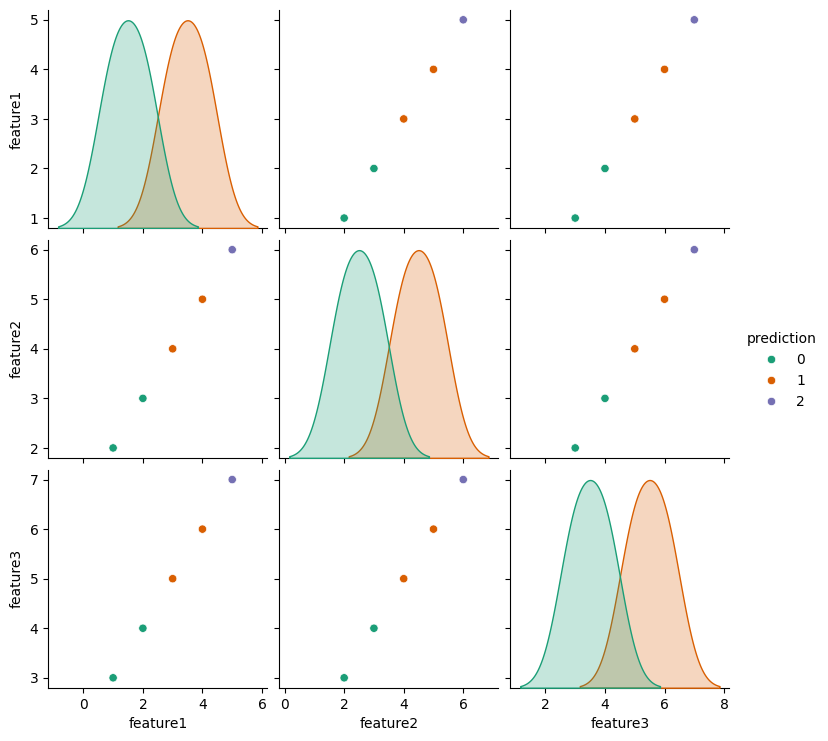

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("KMeansExample") \
    .getOrCreate()

try:

    data = spark.createDataFrame([
        (1, 2, 3),
        (2, 3, 4),
        (3, 4, 5),
        (4, 5, 6),
        (5, 6, 7)
    ], ["feature1", "feature2", "feature3"])

    # Define feature columns
    feature_columns = ['feature1', 'feature2', 'feature3']

    # VectorAssembler to assemble feature columns into a single feature vector
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    # Transform the data
    data = assembler.transform(data)

    # Define the KMeans model
    kmeans = KMeans(featuresCol="features", k=3)

    # Train the KMeans model
    kmeans_model = kmeans.fit(data)

    # Make predictions
    predictions = kmeans_model.transform(data)

    # Show cluster centers
    print("Cluster Centers:")
    centers = kmeans_model.clusterCenters()
    for center in centers:
        print(center)

    # Visualize the clusters
    features_pd = data.select("feature1", "feature2", "feature3").toPandas()
    predictions_pd = predictions.select("prediction").toPandas()
    features_pd['prediction'] = predictions_pd['prediction']

    sns.pairplot(features_pd, hue="prediction", palette="Dark2", diag_kind="kde")
    plt.show()

except Exception as e:
    print("An error occurred:", e)

finally:
    # Stop SparkSession when done
    spark.stop()


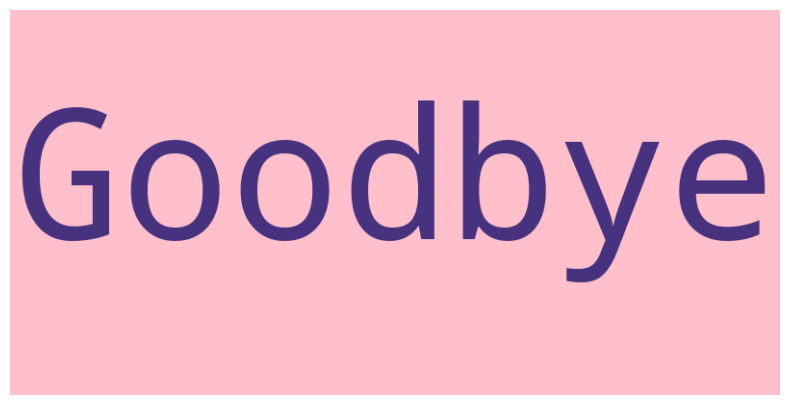

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Text to visualize
text = "Goodbye!"

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='pink').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
